In [20]:
#Importing Libraries 
import warnings
warnings.filterwarnings('ignore')

import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Dense, Activation

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
nltk.download('vader_lexicon')

from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\harsh\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [21]:
#Importing the Numerical Dataset 
#Reading the Datasets into pandas

stock_price = pd.read_csv("C:/Users/harsh/Downloads/HDFCBANK.NS (2).csv")
stock_headlines = pd.read_csv("C:/Users/harsh/Downloads/india-news-headlines.csv")

In [22]:
# Displaying stock price dataset
stock_price.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-04-16,23.495001,24.190001,22.900000,23.565001,20.196486,981290.0
1,2001-04-17,23.600000,24.799999,23.500000,24.575001,21.062107,1308550.0
2,2001-04-18,24.700001,24.990000,24.299999,24.525000,21.019253,1129190.0
3,2001-04-19,24.600000,25.000000,23.600000,23.959999,20.535017,2337880.0
4,2001-04-20,24.500000,24.500000,23.504999,24.365000,21.057901,1533010.0


In [23]:
# Displaying news headlines dataset
stock_headlines.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [24]:
#Feature Engineering
#Displaying number of records in both stock_price and stock_headlines datasets
len(stock_price), len(stock_headlines)

(5242, 3424067)

In [25]:
#Checking for null values in both the datasets
stock_price.isna().any(), stock_headlines.isna().any()


(Date         False
 Open          True
 High          True
 Low           True
 Close         True
 Adj Close     True
 Volume        True
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

In [26]:
#Removing Null Values
stock_headlines = stock_headlines.dropna()
stock_price = stock_price.dropna()

In [27]:
#Checking for null values in both the datasets
stock_price.isna().any(), stock_headlines.isna().any()

(Date         False
 Open         False
 High         False
 Low          False
 Close        False
 Adj Close    False
 Volume       False
 dtype: bool,
 publish_date         False
 headline_category    False
 headline_text        False
 dtype: bool)

In [28]:
# Dropping duplicates from Stock Prices dataset
stock_price = stock_price.drop_duplicates()

# Coverting the datatype of column 'Date' from type object to type 'datetime'
stock_price['Date'] = pd.to_datetime(stock_price['Date']).dt.normalize()

# Filtering the important columns required
stock_price = stock_price.filter(['Date', 'Close', 'Open', 'High', 'Low', 'Volume'])

# Setting column 'Date' as the index column
stock_price.set_index('Date', inplace= True)

# Sorting the data according to the index i.e 'Date'
stock_price = stock_price.sort_index(ascending=True, axis=0)
stock_price

,Close,Open,High,Low,Volume
Date,,,,,
2001-04-16,23.565001,23.495001,24.190001,22.900000,981290.0
2001-04-17,24.575001,23.600000,24.799999,23.500000,1308550.0
2001-04-18,24.525000,24.700001,24.990000,24.299999,1129190.0
2001-04-19,23.959999,24.600000,25.000000,23.600000,2337880.0
2001-04-20,24.365000,24.500000,24.500000,23.504999,1533010.0
...,...,...,...,...,...
2022-04-07,1516.750000,1541.300049,1541.349976,1513.699951,20390866.0
2022-04-08,1514.650024,1512.099976,1525.750000,1497.300049,20628161.0
2022-04-11,1496.150024,1506.000000,1510.000000,1493.250000,10399533.0


In [29]:
# Dropping duplicates from Stocks Headlines dataset
stock_headlines = stock_headlines.drop_duplicates()

# Coverting the datatype of column 'Date' from type string to type 'datetime'
stock_headlines['publish_date'] = stock_headlines['publish_date'].astype(str)
stock_headlines['publish_date'] = stock_headlines['publish_date'].apply(lambda x: x[0:4]+'-'+x[4:6]+'-'+x[6:8])
stock_headlines['publish_date'] = pd.to_datetime(stock_headlines['publish_date']).dt.normalize()

# Filtering the important columns required
stock_headlines = stock_headlines.filter(['publish_date', 'headline_text'])

# Grouping the news headlines according to 'Date'
stock_headlines = stock_headlines.groupby(['publish_date'])['headline_text'].apply(lambda x: ','.join(x)).reset_index()

# Setting column 'Date' as the index column
stock_headlines.set_index('publish_date', inplace= True)

# Sorting the data according to the index i.e 'Date'
stock_headlines = stock_headlines.sort_index(ascending=True, axis=0)
stock_headlines

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


In [30]:
# Concatenating the datasets stock price and stock headlines
stock_data = pd.concat([stock_price, stock_headlines], axis=1)

# Dropping the null values if any
stock_data.dropna(axis=0, inplace=True)

# Displaying the combined stock_data
stock_data

,Close,Open,High,Low,Volume,headline_text
2001-04-16,23.565001,23.495001,24.190001,22.900000,981290.0,"PM dares Cong to bring no-trust motion,Sangh P..."
2001-04-17,24.575001,23.600000,24.799999,23.500000,1308550.0,Cancer and the science of alternative therapie...
2001-04-18,24.525000,24.700001,24.990000,24.299999,1129190.0,"Congress isolated; but stalls Parliament,Cabin..."
2001-04-19,23.959999,24.600000,25.000000,23.600000,2337880.0,"Now Bangla troops occupy Assam village,GSLV la..."
2001-04-20,24.365000,24.500000,24.500000,23.504999,1533010.0,"Bangla troops pull out of Meghalaya village,Go..."
...,...,...,...,...,...,...
2020-12-24,1397.099976,1389.400024,1404.000000,1377.000000,7476094.0,How to set the mood for sex during cold winter...
2020-12-28,1412.849976,1405.000000,1421.000000,1404.000000,5849597.0,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,1427.199951,1421.050049,1434.750000,1420.000000,7247673.0,Man recovers charred remains of 'thief' from h...
2020-12-30,1432.500000,1439.900024,1439.900024,1413.000000,8108363.0,Numerology Readings 30 December 2020: Predicti...


In [31]:
#Calculating Sentiment Scores
#Adding empty sentiment columns to stock_data for later calculation
stock_data['compound'] = ''
stock_data['negative'] = ''
stock_data['neutral'] = ''
stock_data['positive'] = ''
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-04-16,23.565001,23.495001,24.190001,22.900000,981290.0,"PM dares Cong to bring no-trust motion,Sangh P...",,,,
2001-04-17,24.575001,23.600000,24.799999,23.500000,1308550.0,Cancer and the science of alternative therapie...,,,,
2001-04-18,24.525000,24.700001,24.990000,24.299999,1129190.0,"Congress isolated; but stalls Parliament,Cabin...",,,,
2001-04-19,23.959999,24.600000,25.000000,23.600000,2337880.0,"Now Bangla troops occupy Assam village,GSLV la...",,,,
2001-04-20,24.365000,24.500000,24.500000,23.504999,1533010.0,"Bangla troops pull out of Meghalaya village,Go...",,,,


In [32]:
# Importing requires libraries to analyze the sentiments
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

# Instantiating the Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# Calculating sentiment scores
stock_data['compound'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['compound'])
stock_data['negative'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neg'])
stock_data['neutral'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['neu'])
stock_data['positive'] = stock_data['headline_text'].apply(lambda x: sid.polarity_scores(x)['pos'])

# Displaying the stock data
stock_data.head()

,Close,Open,High,Low,Volume,headline_text,compound,negative,neutral,positive
2001-04-16,23.565001,23.495001,24.190001,22.900000,981290.0,"PM dares Cong to bring no-trust motion,Sangh P...",-0.8673,0.098,0.855,0.047
2001-04-17,24.575001,23.600000,24.799999,23.500000,1308550.0,Cancer and the science of alternative therapie...,-0.8665,0.119,0.815,0.066
2001-04-18,24.525000,24.700001,24.990000,24.299999,1129190.0,"Congress isolated; but stalls Parliament,Cabin...",0.9543,0.055,0.808,0.136
2001-04-19,23.959999,24.600000,25.000000,23.600000,2337880.0,"Now Bangla troops occupy Assam village,GSLV la...",0.8860,0.047,0.841,0.112
2001-04-20,24.365000,24.500000,24.500000,23.504999,1533010.0,"Bangla troops pull out of Meghalaya village,Go...",0.8392,0.081,0.800,0.119


In [33]:
#Finalising Stock Data and writing to Disk
#Dropping the 'headline_text' which is unwanted now
stock_data.drop(['headline_text'], inplace=True, axis=1)

# Rearranging the columns of the whole stock_data
stock_data = stock_data[['Close', 'compound', 'negative', 'neutral', 'positive', 'Open', 'High', 'Low', 'Volume']]

# Displaying the final stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
2001-04-16,23.565001,-0.8673,0.098,0.855,0.047,23.495001,24.190001,22.900000,981290.0
2001-04-17,24.575001,-0.8665,0.119,0.815,0.066,23.600000,24.799999,23.500000,1308550.0
2001-04-18,24.525000,0.9543,0.055,0.808,0.136,24.700001,24.990000,24.299999,1129190.0
2001-04-19,23.959999,0.8860,0.047,0.841,0.112,24.600000,25.000000,23.600000,2337880.0
2001-04-20,24.365000,0.8392,0.081,0.800,0.119,24.500000,24.500000,23.504999,1533010.0


In [36]:
# Writing the prepared stock_data to disk
stock_data.to_csv("C:/Users/harsh/Downloads/stock_datafinal.csv")

In [37]:
# Re-reading the stock_data into pandas dataframe
stock_data = pd.read_csv("C:/Users/harsh/Downloads/stock_datafinal.csv", index_col = False)

# Renaming the column
stock_data.rename(columns={'Unnamed: 0':'Date'}, inplace = True)

# Setting the column 'Date' as the index column
stock_data.set_index('Date', inplace=True)

# Displaying the stock_data
stock_data.head()

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-04-16,23.565001,-0.8673,0.098,0.855,0.047,23.495001,24.190001,22.900000,981290.0
2001-04-17,24.575001,-0.8665,0.119,0.815,0.066,23.600000,24.799999,23.500000,1308550.0
2001-04-18,24.525000,0.9543,0.055,0.808,0.136,24.700001,24.990000,24.299999,1129190.0
2001-04-19,23.959999,0.8860,0.047,0.841,0.112,24.600000,25.000000,23.600000,2337880.0
2001-04-20,24.365000,0.8392,0.081,0.800,0.119,24.500000,24.500000,23.504999,1533010.0


In [38]:
# Displaying the shape i.e. number of rows and columns of stock_data
stock_data.shape

(4902, 9)

In [39]:
# Checking for null values
stock_data.isna().any()

Close       False
compound    False
negative    False
neutral     False
positive    False
Open        False
High        False
Low         False
Volume      False
dtype: bool

In [40]:
# Displaying stock_data statistics
stock_data.describe(include='all')

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
count,4902.000000,4902.000000,4902.000000,4902.000000,4902.000000,4902.000000,4902.000000,4902.000000,4.902000e+03
mean,366.834902,-0.884676,0.127101,0.786243,0.086655,366.936827,370.636004,362.791005,5.755997e+06
std,374.459168,0.431630,0.023037,0.031568,0.018899,374.702966,377.716859,371.106661,6.153213e+06
min,18.799999,-1.000000,0.000000,0.000000,0.000000,18.900000,19.184999,18.410000,0.000000e+00
25%,72.649998,-0.999800,0.114000,0.766000,0.076000,72.491253,74.000000,71.132500,2.258871e+06
50%,222.279999,-0.999200,0.128000,0.782000,0.087000,223.099998,226.045006,220.000000,4.190904e+06
75%,539.918747,-0.995100,0.142000,0.804000,0.097000,539.250000,544.250000,534.456268,7.220772e+06
max,1441.800049,1.000000,0.400000,1.000000,0.600000,1451.300049,1464.400024,1425.500000,2.011300e+08


In [41]:
# Displaying stock_data information
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4902 entries, 2001-04-16 to 2020-12-31
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Close     4902 non-null   float64
 1   compound  4902 non-null   float64
 2   negative  4902 non-null   float64
 3   neutral   4902 non-null   float64
 4   positive  4902 non-null   float64
 5   Open      4902 non-null   float64
 6   High      4902 non-null   float64
 7   Low       4902 non-null   float64
 8   Volume    4902 non-null   float64
dtypes: float64(9)
memory usage: 383.0+ KB


Text(0, 0.5, 'Close Price ($)')

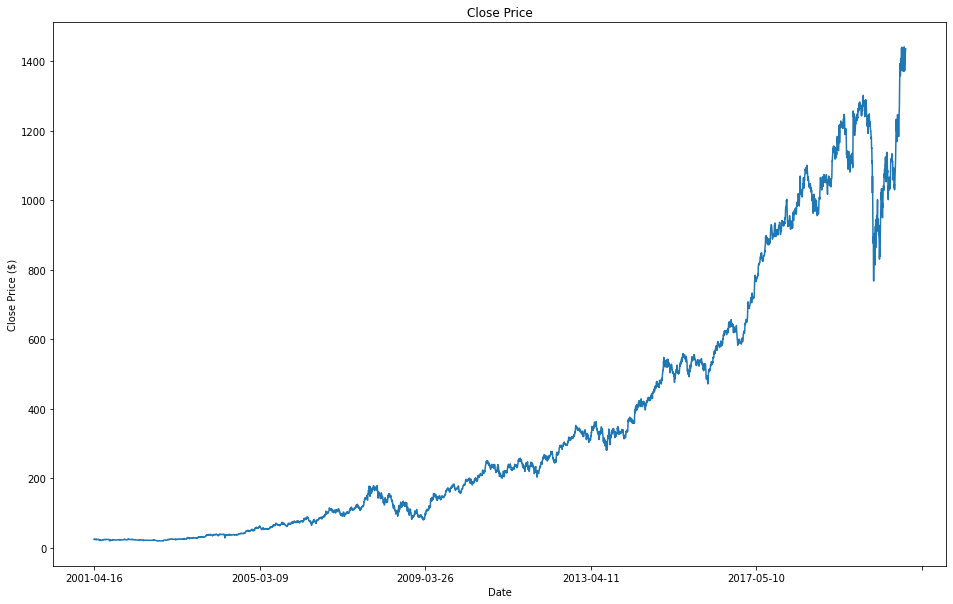

In [42]:
#EDA of Stock Data
#Setting figure size
plt.figure(figsize=(16,10))

# Plotting close price
stock_data['Close'].plot()

# Setting plot title, x and y labels
plt.title("Close Price")
plt.xlabel('Date')
plt.ylabel('Close Price ($)')

In [43]:
# Calculating 7 day rolling mean
stock_data.rolling(7).mean().head(20)

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-04-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-24,24.157857,-0.079357,0.090286,0.828857,0.080714,24.172857,24.592857,23.649285,1.313633e+06
2001-04-25,24.180000,0.157271,0.085000,0.827000,0.087857,24.202143,24.551428,23.750000,1.212370e+06
2001-04-26,24.067857,0.412800,0.073143,0.832000,0.094714,24.236429,24.436429,23.767857,1.056804e+06


<AxesSubplot:xlabel='Date'>

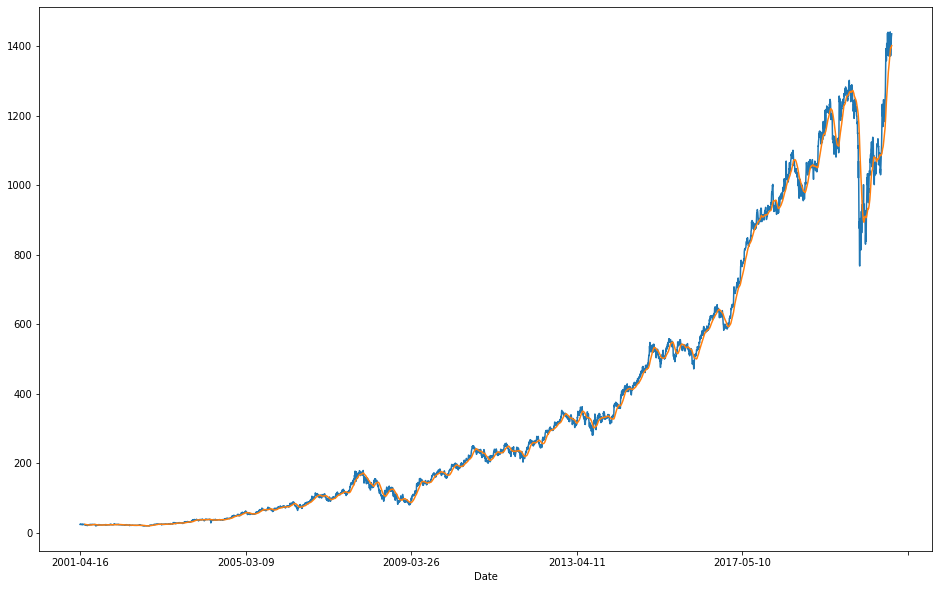

In [44]:
# Setting figure size
plt.figure(figsize=(16,10))

# Plotting the close price and a 30-day rolling mean of close price
stock_data['Close'].plot()
stock_data.rolling(window=30).mean()['Close'].plot()

In [45]:
# Displaying stock_data
stock_data

,Close,compound,negative,neutral,positive,Open,High,Low,Volume
Date,,,,,,,,,
2001-04-16,23.565001,-0.8673,0.098,0.855,0.047,23.495001,24.190001,22.900000,981290.0
2001-04-17,24.575001,-0.8665,0.119,0.815,0.066,23.600000,24.799999,23.500000,1308550.0
2001-04-18,24.525000,0.9543,0.055,0.808,0.136,24.700001,24.990000,24.299999,1129190.0
2001-04-19,23.959999,0.8860,0.047,0.841,0.112,24.600000,25.000000,23.600000,2337880.0
2001-04-20,24.365000,0.8392,0.081,0.800,0.119,24.500000,24.500000,23.504999,1533010.0
...,...,...,...,...,...,...,...,...,...
2020-12-24,1397.099976,-0.9971,0.082,0.854,0.064,1389.400024,1404.000000,1377.000000,7476094.0
2020-12-28,1412.849976,-0.9997,0.126,0.789,0.085,1405.000000,1421.000000,1404.000000,5849597.0
2020-12-29,1427.199951,-0.9998,0.136,0.774,0.090,1421.050049,1434.750000,1420.000000,7247673.0


In [46]:
#Data Preparation for Modelling
# Calculating data_to_use
percentage_of_data = 1.0
data_to_use = int(percentage_of_data*(len(stock_data)-1))

# Using 80% of data for training
train_end = int(data_to_use*0.8)
total_data = len(stock_data)
start = total_data - data_to_use

# Printing number of records in the training and test datasets
print("Number of records in Training Data:", train_end)
print("Number of records in Test Data:", total_data - train_end)

Number of records in Training Data: 3920
Number of records in Test Data: 982


In [47]:
# Predicting one step ahead
steps_to_predict = 1

# Capturing data to be used for each column
close_price = stock_data.iloc[start:total_data,0] #Close
compound = stock_data.iloc[start:total_data,1] #Compound
negative = stock_data.iloc[start:total_data,2] #Neg
neutral = stock_data.iloc[start:total_data,3] #Neu
positive = stock_data.iloc[start:total_data,4] #Pos
open_price = stock_data.iloc[start:total_data,5] #Open
high = stock_data.iloc[start:total_data,6] #High
low = stock_data.iloc[start:total_data,7] #Low
volume = stock_data.iloc[start:total_data,8] #Volume

# Printing close price
print("Close Price:")
close_price

Close Price:


Date
2001-04-17      24.575001
2001-04-18      24.525000
2001-04-19      23.959999
2001-04-20      24.365000
2001-04-23      24.334999
                 ...     
2020-12-24    1397.099976
2020-12-28    1412.849976
2020-12-29    1427.199951
2020-12-30    1432.500000
2020-12-31    1436.300049
Name: Close, Length: 4901, dtype: float64

In [48]:
# Shifting next day close
close_price_shifted = close_price.shift(-1) 

# Shifting next day compound
compound_shifted = compound.shift(-1) 

# Concatenating the captured training data into a dataframe
data = pd.concat([close_price, close_price_shifted, compound, compound_shifted, volume, open_price, high, low], axis=1)

# Setting column names of the revised stock data
data.columns = ['close_price', 'close_price_shifted', 'compound', 'compound_shifted','volume', 'open_price', 'high', 'low']

# Dropping nulls
data = data.dropna()    
data.head(10)

,close_price,close_price_shifted,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,,
2001-04-17,24.575001,24.525000,-0.8665,0.9543,1308550.0,23.600000,24.799999,23.500000
2001-04-18,24.525000,23.959999,0.9543,0.8860,1129190.0,24.700001,24.990000,24.299999
2001-04-19,23.959999,24.365000,0.8860,0.8392,2337880.0,24.600000,25.000000,23.600000
2001-04-20,24.365000,24.334999,0.8392,-0.9745,1533010.0,24.500000,24.500000,23.504999
2001-04-23,24.334999,23.780001,-0.9745,-0.5267,613220.0,24.299999,24.490000,24.125000
2001-04-24,23.780001,23.719999,-0.5267,0.7891,1292290.0,24.014999,24.180000,23.615000
2001-04-25,23.719999,23.790001,0.7891,0.9222,272450.0,23.700001,23.900000,23.605000
2001-04-26,23.790001,23.245001,0.9222,0.7887,219590.0,23.840000,23.995001,23.625000
2001-04-27,23.245001,23.040001,0.7887,-0.8053,515720.0,23.549999,23.600000,22.000000


In [49]:
# Setting the target variable as the shifted close_price
y = data['close_price_shifted']
y

Date
2001-04-17      24.525000
2001-04-18      23.959999
2001-04-19      24.365000
2001-04-20      24.334999
2001-04-23      23.780001
                 ...     
2020-12-23    1397.099976
2020-12-24    1412.849976
2020-12-28    1427.199951
2020-12-29    1432.500000
2020-12-30    1436.300049
Name: close_price_shifted, Length: 4900, dtype: float64

In [50]:
# Setting the features dataset for prediction  
cols = ['close_price', 'compound', 'compound_shifted', 'volume', 'open_price', 'high', 'low']
x = data[cols]
x

,close_price,compound,compound_shifted,volume,open_price,high,low
Date,,,,,,,
2001-04-17,24.575001,-0.8665,0.9543,1308550.0,23.600000,24.799999,23.500000
2001-04-18,24.525000,0.9543,0.8860,1129190.0,24.700001,24.990000,24.299999
2001-04-19,23.959999,0.8860,0.8392,2337880.0,24.600000,25.000000,23.600000
2001-04-20,24.365000,0.8392,-0.9745,1533010.0,24.500000,24.500000,23.504999
2001-04-23,24.334999,-0.9745,-0.5267,613220.0,24.299999,24.490000,24.125000
...,...,...,...,...,...,...,...
2020-12-23,1375.650024,-0.9996,-0.9971,7733697.0,1367.500000,1380.949951,1361.050049
2020-12-24,1397.099976,-0.9971,-0.9997,7476094.0,1389.400024,1404.000000,1377.000000
2020-12-28,1412.849976,-0.9997,-0.9998,5849597.0,1405.000000,1421.000000,1404.000000


In [52]:
#Scaling the Target Variable and the Feature Dataset
#Since we are using LSTM to predict stock prices, which is a time series data, it is important to understand that LSTM can be very sensitive to the scale of the data. 
#Right now, if the data is observed, it is present in different scales. Therefore, it is important to re-scale the data so that the range of the dataset is same,
#for almost all records. Here a feature range of (-1,1) is used.

In [53]:
# Scaling the feature dataset
scaler_x = preprocessing.MinMaxScaler (feature_range=(-1, 1))
x = np.array(x).reshape((len(x) ,len(cols)))
x = scaler_x.fit_transform(x)

# Scaling the target variable
scaler_y = preprocessing.MinMaxScaler (feature_range=(-1, 1))
y = np.array (y).reshape ((len( y), 1))
y = scaler_y.fit_transform (y)

# Displaying the scaled feature dataset and the target variable
x, y

(array([[-0.99188334, -0.8665    ,  0.9543    , ..., -0.99343759,
         -0.99222953, -0.99276521],
        [-0.99195362,  0.9543    ,  0.886     , ..., -0.9919017 ,
         -0.99196659, -0.99162811],
        [-0.99274772,  0.886     ,  0.8392    , ..., -0.99204133,
         -0.99195275, -0.99262307],
        ...,
        [ 0.95931121, -0.9997    , -0.9998    , ...,  0.93535319,
          0.9399397 ,  0.96944048],
        [ 0.97947983, -0.9998    , -0.9998    , ...,  0.9577632 ,
          0.95896801,  0.99218245],
        [ 0.98692895, -0.9998    , -0.9996    , ...,  0.98408262,
          0.96609501,  0.98223284]]),
 array([[-0.99195362],
        [-0.99274772],
        [-0.9921785 ],
        ...,
        [ 0.97947983],
        [ 0.98692895],
        [ 0.99226985]]))

In [54]:
#Dividing the dataset into Training and Test
#Normally for any other dataset train_test_split from sklearn package is used, but for time series data like stock prices which is dependent on date,
#the dataset is divided into train and test dataset in a different way as shown below. In timeseries data, an observation for a particular date is always 
#dependent on the previous date records.

In [55]:
# Preparing training and test dataset
X_train = x[0 : train_end,]
X_test = x[train_end+1 : len(x),]    
y_train = y[0 : train_end] 
y_test = y[train_end+1 : len(y)]  

# Printing the shape of the training and the test datasets
print('Number of rows and columns in the Training set X:', X_train.shape, 'and y:', y_train.shape)
print('Number of rows and columns in the Test set X:', X_test.shape, 'and y:', y_test.shape)


Number of rows and columns in the Training set X: (3920, 7) and y: (3920, 1)
Number of rows and columns in the Test set X: (979, 7) and y: (979, 1)


In [56]:
# Reshaping the feature dataset for feeding into the model
X_train = X_train.reshape (X_train.shape + (1,)) 
X_test = X_test.reshape(X_test.shape + (1,))

# Printing the re-shaped feature dataset
print('Shape of Training set X:', X_train.shape)
print('Shape of Test set X:', X_test.shape)

Shape of Training set X: (3920, 7, 1)
Shape of Test set X: (979, 7, 1)


In [57]:
# Setting the seed to achieve consistent and less random predictions at each execution
np.random.seed(2016)

# Setting the model architecture
model=Sequential()
model.add(LSTM(100,return_sequences=True,activation='tanh',input_shape=(len(cols),1)))
model.add(Dropout(0.1))
model.add(LSTM(100,return_sequences=True,activation='tanh'))
model.add(Dropout(0.1))

model.add(LSTM(100,activation='tanh'))
model.add(Dropout(0.1))
model.add(Dense(1))

# Printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [58]:
# Compiling the model
model.compile(loss='mse' , optimizer='adam')

# Fitting the model using the training dataset
model.fit(X_train, y_train, validation_split=0.35, epochs=50, batch_size=8, verbose=1)

Epoch 1/50
319/319 [==============================] - 11s 15ms/step - loss: 0.0244 - val_loss: 0.2299
Epoch 2/50
319/319 [==============================] - 4s 12ms/step - loss: 0.0102 - val_loss: 0.1771
Epoch 3/50
319/319 [==============================] - 3s 10ms/step - loss: 0.0067 - val_loss: 0.0372
Epoch 4/50
319/319 [==============================] - 3s 10ms/step - loss: 0.0034 - val_loss: 0.0118
Epoch 5/50
319/319 [==============================] - 3s 10ms/step - loss: 0.0020 - val_loss: 0.0167
Epoch 6/50
319/319 [==============================] - 3s 10ms/step - loss: 0.0017 - val_loss: 0.0059
Epoch 7/50
319/319 [==============================] - 4s 13ms/step - loss: 0.0015 - val_loss: 0.0069
Epoch 8/50
319/319 [==============================] - 4s 11ms/step - loss: 0.0016 - val_loss: 0.0043
Epoch 9/50
319/319 [==============================] - 4s 12ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/50
319/319 [==============================] - 4s 11ms/step - loss: 0.0012 - val_l

In [59]:
# Saving the model as a json file
model_json = model.to_json()
with open('model.json', 'w') as json_file:
    json_file.write(model_json)
    
# Serialize weights to HDF5
model.save_weights("C:/Users/harsh/Downloads/model.h5")
print('Model is saved to the disk')

Model is saved to the disk


In [60]:
# Performing predictions
predictions = model.predict(X_test) 

# Unscaling the predictions
predictions = scaler_y.inverse_transform(np.array(predictions).reshape((len(predictions), 1)))

# Printing the predictions
print('Predictions:')
predictions[0:5]

Predictions:


array([[568.41986],
       [568.9215 ],
       [570.53   ],
       [572.23224],
       [573.3666 ]], dtype=float32)

In [61]:
# Calculating the training mean-squared-error
train_loss = model.evaluate(X_train, y_train, batch_size = 1)

# Calculating the test mean-squared-error
test_loss = model.evaluate(X_test, y_test, batch_size = 1)

# Printing the training and the test mean-squared-errors
print('Train Loss =', round(train_loss,4))
print('Test Loss =', round(test_loss,4))

979/979 [==============================] - 2s 2ms/step - loss: 0.1111
Train Loss = 0.0004
Test Loss = 0.1111


In [62]:
# Calculating root mean squared error
root_mean_square_error = np.sqrt(np.mean(np.power((y_test - predictions),2)))
print('Root Mean Square Error =', round(root_mean_square_error,4))

Root Mean Square Error = 813.4787


In [63]:
# Calculating root mean squared error using sklearn.metrics package
rmse = metrics.mean_squared_error(y_test, predictions)
print('Root Mean Square Error (sklearn.metrics) =', round(np.sqrt(rmse),4))

Root Mean Square Error (sklearn.metrics) = 813.4787


In [64]:
# Unscaling the test feature dataset, x_test
X_test = scaler_x.inverse_transform(np.array(X_test).reshape((len(X_test), len(cols))))

# Unscaling the test y dataset, y_test
y_train = scaler_y.inverse_transform(np.array(y_train).reshape((len(y_train), 1)))
y_test = scaler_y.inverse_transform(np.array(y_test).reshape((len(y_test), 1)))

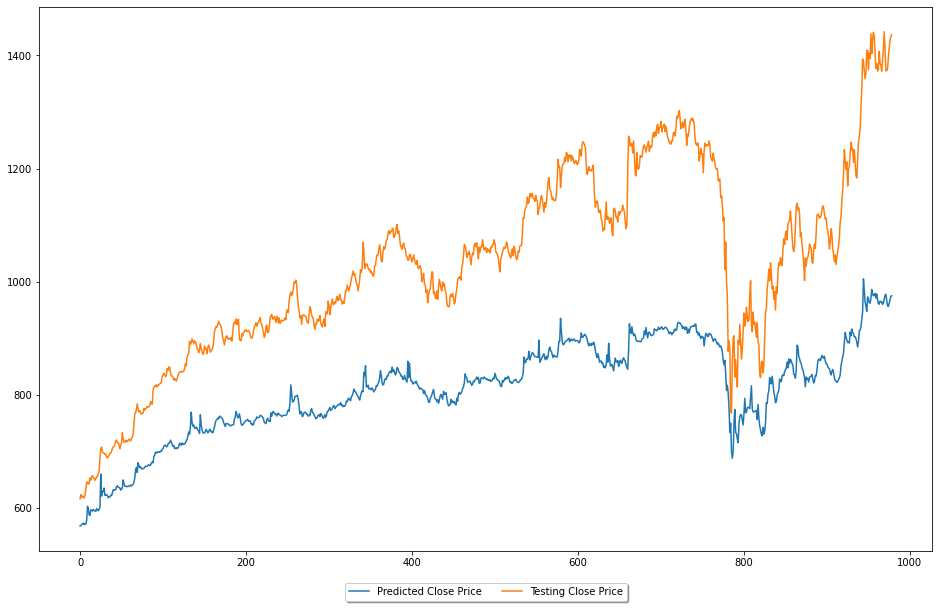

In [65]:
# Plotting
plt.figure(figsize=(16,10))

# plt.plot([row[0] for row in y_train], label="Training Close Price")
plt.plot(predictions, label="Predicted Close Price")
plt.plot([row[0] for row in y_test], label="Testing Close Price")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2)
plt.show()